In [2]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
#filename = "./l3higgs/l3higgs189/higgs_data.root"
channels = ['eeqq','qq','wen','ww','zee','zz','higgs_85','higgs_90','higgs_95', 'data']
dfnames = []
dflist = []

for channel in channels:
    filename = './l3higgs189/higgs_' + channel + '.csv'
    dfname = 'df_' + channel
    
    vars()[dfname] = pd.read_csv(filename)
    dfnames.append(dfname)
    dflist.append(vars()[dfname])

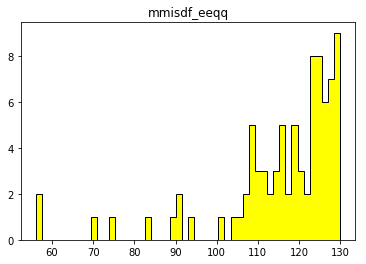

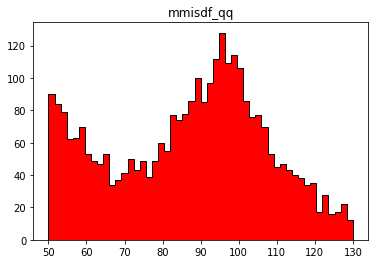

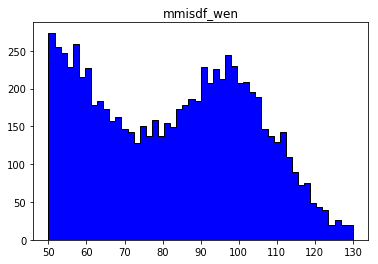

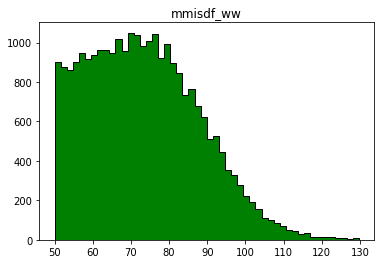

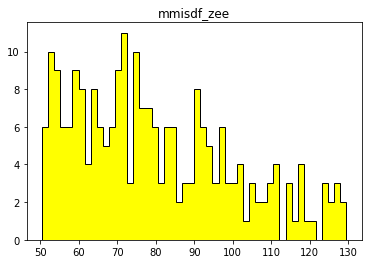

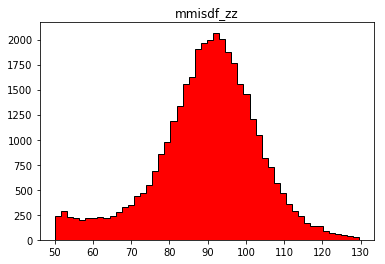

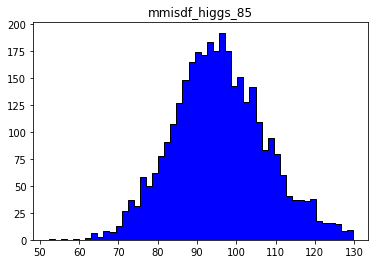

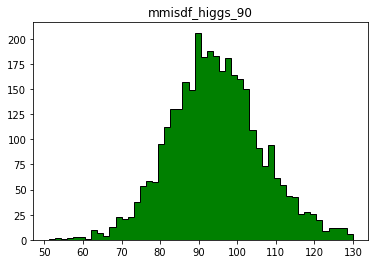

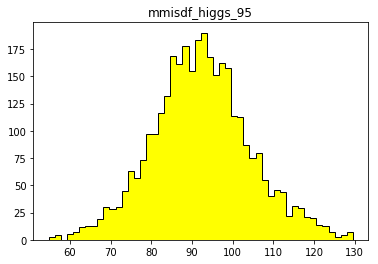

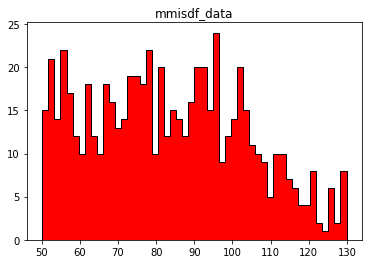

In [60]:
#check variables for each channel, try to make some sense out of them
varlist = ['mmis']
colors = ['yellow', 'red', 'blue', 'green']
bins = 50
for dfname in dfnames:
    index = dfnames.index(dfname)
    for varname in varlist:
        plt.hist((dflist[index])[varname], bins=bins, color=colors[index%len(colors)], ec="black", histtype="stepfilled")
        plt.title(varname + '' + dfname)
        plt.show()
